# ⋆｡°✩Análise de Sentimentos em postagens do Twitter ᝰ.ᐟ

In [258]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# --- Imports ---
import re
import numpy as np
import pandas as pd
from collections import Counter
from nltk.stem import PorterStemmer  # stemming (inglês)
# pip install nltk  # se não tiver

## Dados


In [259]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


In [260]:
data_dir = Path(path)
csv_path = next(p for p in data_dir.rglob("training.1600000.processed.noemoticon.csv"))

df = pd.read_csv(csv_path, encoding="latin-1", header=None)
df.columns = ["target", "ids", "date", "flag", "user", "text"]
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [261]:
print(f"\nValores nulos por coluna:\n{df.isnull().sum()}")
print(f"\nDistribuição das classes:\n{df['target'].value_counts()}")


Valores nulos por coluna:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Distribuição das classes:
target
0    800000
4    800000
Name: count, dtype: int64


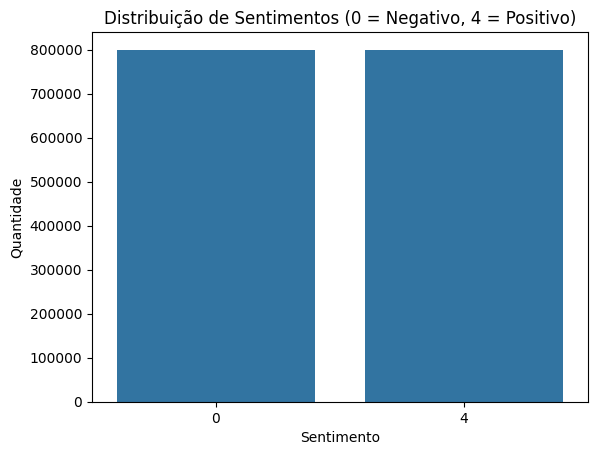

In [262]:
# Visualização da distribuição
sns.countplot(x='target', data=df)
plt.title("Distribuição de Sentimentos (0 = Negativo, 4 = Positivo)")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.show()

In [263]:
# Comprimento dos textos
df['text_length'] = df['text'].apply(len)

In [264]:
# Exemplo de textos positivos e negativos
print(f"\n💬 Exemplo de texto negativo:\n{df[df['target'] == 0]['text'].iloc[1]}")
print(f"\n💬 Exemplo de texto positivo:\n{df[df['target'] == 4]['text'].iloc[1]}")


💬 Exemplo de texto negativo:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

💬 Exemplo de texto positivo:
im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!


## Pré-processamento dos dados

In [265]:
# ===== Imports, seed e device =====
import os, re, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

#### Reprodutibilidade

In [266]:
# Reprodutibilidade
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


#### Amostra com 50k (estratificado por classe)

In [267]:
N = 70_000

# calcula proporção real 0/4 e amostra mantendo a proporção
vc = df["target"].value_counts()
neg = int(vc.get(0, 0))
pos = int(vc.get(4, 0))
tot = max(neg + pos, 1)
n_neg = int(round(N * (neg / tot)))
n_pos = N - n_neg

df_neg = df[df["target"] == 0].sample(n=min(n_neg, neg), random_state=42) if neg else df.iloc[0:0]
df_pos = df[df["target"] == 4].sample(n=min(n_pos, pos), random_state=42) if pos else df.iloc[0:0]

df_small = pd.concat([df_neg, df_pos]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_small["target"].value_counts())
df_small.head()

target
4    35000
0    35000
Name: count, dtype: int64


,target,ids,date,flag,user,text,text_length
0,4,2182150760,Mon Jun 15 12:47:20 PDT 2009,NO_QUERY,MadisonMary,@taccah oh i know im right,27
1,4,1997234085,Mon Jun 01 16:29:29 PDT 2009,NO_QUERY,alextirrell,is kinda sleepy? Will lie down for a while... ...,59
2,4,2067586858,Sun Jun 07 12:36:29 PDT 2009,NO_QUERY,IrisJC,My besties @IsabellaOrneli &amp; @NatachaSesif...,97
3,0,2058854214,Sat Jun 06 15:45:37 PDT 2009,NO_QUERY,xxgrace25xx,sittin at home bored!!!!!,26
4,4,1692021287,Sun May 03 19:06:32 PDT 2009,NO_QUERY,frankparker,"@tweetles Lol I know, well nite nite for now ...",52


## Normaliza rótulo 0/1 em df_small (Sentiment140 usa 0 e 4)

In [268]:
df_small["label"] = (df_small["target"] == 4).astype(int)

In [269]:
# 1) RAW
df_small["raw"] = df_small["text"].astype(str)

#### Limpeza de texto + lowercase

- remove URLs e menções
- remove '#' (mantém a palavra da hashtag)
- remove caracteres especiais (fica só letras/dígitos/espaço)
- lowercase

In [270]:
# ==================================
def basic_clean(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)          # remove URLs
    s = re.sub(r"@\w+|#\w+", " ", s)                 # remove @menções e #hashtags
    s = re.sub(r"[^a-zà-öø-ÿ0-9\s]+", " ", s)        # remove pontuações/emoji
    s = re.sub(r"\s+", " ", s).strip()
    return s

# 2)
df_small["clean"] = df_small["raw"].map(basic_clean)

#### Stemming (Porter) : reduz variações (play, playing -> play)

 (Também te lemmatization, veja alternativa abaixo)


In [271]:
'''É um processo mais simples e "bruto" de cortar palavras até sua raiz.
Usa regras de truncagem (ex.: remover sufixos ou prefixos).
Não garante que o resultado seja uma palavra real do idioma.

    Exemplo em português: "amando", "amarei", "amador" → "am"

Vantagem → rápido, computacionalmente barato.
Desvantagem → pode perder semântica ou gerar raízes não interpretáveis.'''

# 3) STEMMED (a partir do CLEAN)
stemmer = PorterStemmer()
def stem_line(s: str) -> str:
    # tokenização simples por espaço
    return " ".join(stemmer.stem(tok) for tok in s.split())

df_small["stemmed"] = df_small["clean"].map(stem_line)
df_small[["label", "raw", "clean", "stemmed"]].head(3)

,label,raw,clean,stemmed
0,1,@taccah oh i know im right,oh i know im right,oh i know im right
1,1,is kinda sleepy? Will lie down for a while... ...,is kinda sleepy will lie down for a while out ...,is kinda sleepi will lie down for a while out ...
2,1,My besties @IsabellaOrneli &amp; @NatachaSesif...,my besties amp i have the best friends ever l ...,my besti amp i have the best friend ever l i m...


In [272]:
# !pip install -q spacy
# !python -m spacy download en_core_web_sm


'''É mais sofisticado e linguístico: usa dicionários e análise morfológica.
Reduz palavras à sua forma canônica (lema), que é uma palavra válida.

Considera o contexto e a classe gramatical.

Exemplo: "amando", "amarei", "amador" → "amar"

Vantagem → mantém significado e forma correta da palavra.
Desvantagem → mais lento e depende de recursos linguísticos (dicionários, POS tagging).'''

'''import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])

def lemmatize_line(s: str) -> str:
    doc = nlp(s)
    return " ".join(tok.lemma_ for tok in doc)

df_small["clean_proc"] = df_small["clean"].map(lemmatize_line)

# Define word2idx_clean, idx2word_clean, seqs_clean, max_len_clean, and X_clean
word2idx_clean, idx2word_clean = build_vocab(df_small["clean_proc"].tolist(), vocab_size=50_000, min_freq=2)
seqs_clean = texts_to_sequences(df_small["clean_proc"].tolist(), word2idx_clean)

lengths_clean = np.array([len(s) for s in seqs_clean if len(s) > 0] + [1])
max_len_clean = int(np.percentile(lengths_clean, 95))
max_len_clean = max(max_len_clean, 5)
max_len_clean = min(max_len_clean, 50)

X_clean = pad_sequences(seqs_clean, max_len=max_len_clean, pad_value=word2idx_clean["<PAD>"])'''

'import spacy\nnlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])\n\ndef lemmatize_line(s: str) -> str:\n    doc = nlp(s)\n    return " ".join(tok.lemma_ for tok in doc)\n\ndf_small["clean_proc"] = df_small["clean"].map(lemmatize_line)\n\n# Define word2idx_clean, idx2word_clean, seqs_clean, max_len_clean, and X_clean\nword2idx_clean, idx2word_clean = build_vocab(df_small["clean_proc"].tolist(), vocab_size=50_000, min_freq=2)\nseqs_clean = texts_to_sequences(df_small["clean_proc"].tolist(), word2idx_clean)\n\nlengths_clean = np.array([len(s) for s in seqs_clean if len(s) > 0] + [1])\nmax_len_clean = int(np.percentile(lengths_clean, 95))\nmax_len_clean = max(max_len_clean, 5)\nmax_len_clean = min(max_len_clean, 50)\n\nX_clean = pad_sequences(seqs_clean, max_len=max_len_clean, pad_value=word2idx_clean["<PAD>"])'

#### Vocabulário + sequencialização (sem Keras/TensorFlow)


In [273]:
def build_vocab_from_texts(texts, min_freq=2, max_vocab=50000):
    counter = Counter()
    for tx in texts:
        counter.update(simple_tokenize(tx))
    # reserva 0 e 1
    word2idx = {"<PAD>": 0, "<OOV>": 1}
    for w, c in counter.most_common():
        if c < min_freq:
            continue
        if len(word2idx) >= max_vocab:
            break
        if w not in word2idx:
            word2idx[w] = len(word2idx)
    idx2word = {i:w for w,i in word2idx.items()}
    return word2idx, idx2word

In [274]:
def texts_to_sequences(texts, word2idx):
    oov = word2idx.get("<OOV>", 1)
    seqs = []
    for tx in texts:
        toks = simple_tokenize(tx)
        seqs.append([word2idx.get(t, oov) for t in toks])
    return seqs

#### Padding

Define um tamanho alvo pelo percentil 95 do comprimento dos tweets (é uma boa prática para evitar sequências enormes)

In [275]:
'''def pad_sequences(seqs, max_len, pad_value=0):
    X = np.full((len(seqs), max_len), pad_value, dtype=np.int64)
    for i, s in enumerate(seqs):
        L = min(len(s), max_len)
        if L:
            X[i, :L] = s[:L]
    return X'''

# padroniza comprimento
def pad_to_len(s, L):
      s = s[:L]
      if len(s) < L:
          s = s + [pad_idx]*(L - len(s))
      return s

## Extra

In [276]:
# ===== Definições finais =====
df = df_small.copy()

# y binário 0/1
y = df["label"].to_numpy()

# Variantes de texto
variants = {
    "RAW":     df["raw"].astype(str).tolist(),
    "CLEAN":   df["clean"].astype(str).tolist(),
    "STEMMED": df["stemmed"].astype(str).tolist(),
}
print("[OK] Variantes disponíveis:", list(variants.keys()))
print("[OK] Distribuição de classes:", dict(Counter(y)))

[OK] Variantes disponíveis: ['RAW', 'CLEAN', 'STEMMED']
[OK] Distribuição de classes: {np.int64(1): 35000, np.int64(0): 35000}


In [277]:
# Exemplo: construir buckets por variante (cada variante terá seu próprio vocabulário)
VOCAB_MAX = 50000
MIN_FREQ = 2

seq_buckets = {}
pad_idx_map = {}

for name, texts in variants.items():
    print(f"\n[Building] {name}")
    w2i, i2w = build_vocab_from_texts(texts, min_freq=MIN_FREQ, max_vocab=VOCAB_MAX)
    seqs = texts_to_sequences(texts, w2i)
    lengths = np.array([len(s) for s in seqs if len(s)>0] + [1])
    max_len = int(np.percentile(lengths, 95))  # padding no p95 (reduz truncamento/extensão)
    pad_idx = 0
    pad_idx_map[name] = pad_idx

    X = np.array([pad_to_len(s, max_len) for s in seqs], dtype=np.int64)
    seq_buckets[name] = {
        "X": X,
        "y": y.copy(),
        "word2idx": w2i,
        "idx2word": i2w,
        "max_len": max_len,
        "pad_idx": pad_idx,
    }


[Building] RAW

[Building] CLEAN

[Building] STEMMED


## Vocabulário, sequências e padding por variante

In [278]:
# ===== Vocabulário, sequências e padding por variante =====
VOCAB_MAX = 50000
MIN_FREQ = 2

seq_buckets = {}
pad_idx_map = {}

for name, texts in variants.items():
    print(f"\n[Building] {name}")
    w2i, i2w = build_vocab_from_texts(texts, min_freq=MIN_FREQ, max_vocab=VOCAB_MAX)
    seqs = texts_to_sequences(texts, w2i)
    lengths = np.array([len(s) for s in seqs if len(s)>0] + [1])
    max_len = int(np.percentile(lengths, 95))
    max_len = max(5, min(60, max_len))  # limita max_len pra eficiência
    X = pad_sequences(seqs, max_len=max_len, pad_value=w2i["<PAD>"])
    seq_buckets[name] = {
        "word2idx": w2i, "idx2word": i2w, "X": X, "max_len": max_len
    }
    pad_idx_map[name] = w2i["<PAD>"]
    print(f"[OK] {name}: X={X.shape}, max_len={max_len}, vocab={len(w2i)}")



[Building] RAW
[OK] RAW: X=(70000, 27), max_len=27, vocab=21253

[Building] CLEAN
[OK] CLEAN: X=(70000, 26), max_len=26, vocab=18013

[Building] STEMMED
[OK] STEMMED: X=(70000, 26), max_len=26, vocab=14234


#### Conjuntos de Treino, Teste e Validação

In [279]:
# ===== Splits idênticos (70/15/15) para todas as variantes =====
TRAIN_FRAC = 0.70
VAL_FRAC   = 0.15
TEST_FRAC  = 0.15
assert abs(TRAIN_FRAC + VAL_FRAC + TEST_FRAC - 1.0) < 1e-9

BATCH_SIZE   = 256
NUM_WORKERS  = 2

N   = len(y)
idx = np.arange(N)

# 1) 70% train, 30% temp (val+test)
idx_tr, idx_tmp, y_tr, y_tmp = train_test_split(
    idx, y, train_size=TRAIN_FRAC, random_state=SEED, stratify=y
)

# 2) Do "temp" (30%), pegue 50% para teste e 50% para validação
#    0.15 / (0.15+0.15) = 0.5  -> val/test exatos
rel_test = TEST_FRAC / (VAL_FRAC + TEST_FRAC)  # = 0.5
idx_va, idx_te, y_va, y_te = train_test_split(
    idx_tmp, y_tmp, test_size=rel_test, random_state=SEED, stratify=y_tmp
)

splits = {"train": idx_tr, "val": idx_va, "test": idx_te}
print({k: v.shape for k, v in splits.items()})

# (Opcional) sanity checks
assert len(idx_tr) + len(idx_va) + len(idx_te) == N
assert abs(len(idx_tr)/N - TRAIN_FRAC) < 1e-3
assert abs(len(idx_va)/N - VAL_FRAC)   < 1e-3
assert abs(len(idx_te)/N - TEST_FRAC)  < 1e-3

{'train': (49000,), 'val': (10500,), 'test': (10500,)}


#### DataLoaders

## Arquitetura: GRU (Gated Recurrent Unit)

Porque escolhemos o GRU ao invez de LSTM:

Tweets são curtos (poucas dezenas de tokens).
GRU tem menos parâmetros → treina mais rápido e costuma atingir acurácia similar à LSTM nesse tipo de tarefa.
Menor risco de overfitting com base média/pequena como 50k (principalmente se for word-level).

In [280]:
# ===== Modelo RNN(tanh) many-to-one e GRU (opcional) =====
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=128, num_layers=1,
                 bidirectional=False, dropout=0.2, pad_idx=0, use_packing=True, nonlinearity='tanh'):
        super().__init__()
        assert nonlinearity in ('tanh', 'relu'), "nonlinearity deve ser 'tanh' ou 'relu'"
        self.pad_idx = pad_idx
        self.use_packing = use_packing
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                          nonlinearity=nonlinearity, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)

    def forward(self, x):
        # x: (B, T)
        emb = self.embedding(x)  # (B, T, E)
        if self.use_packing:
            lengths = (x != self.pad_idx).sum(dim=1).cpu()
            packed = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
            _, h = self.rnn(packed)  # h: (num_layers*num_directions, B, H)
        else:
            _, h = self.rnn(emb)
        if self.rnn.bidirectional:
            h_last = torch.cat([h[-2], h[-1]], dim=1)  # concat direções
        else:
            h_last = h[-1]  # (B, H)
        logits = self.fc(self.dropout(h_last)).squeeze(1)  # (B,)
        return logits


# Mantemos a versão GRU existente (também many-to-one).

# ===== Modelo GRU com packing =====
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=128, num_layers=1,
                 bidirectional=False, dropout=0.2, pad_idx=0, use_packing=True,
                 emb_dropout=0.0):
        super().__init__()
        self.pad_idx = pad_idx
        self.use_packing = use_packing
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.gru = nn.GRU(
            emb_dim, hidden_dim, num_layers=num_layers, batch_first=True,
            bidirectional=bidirectional
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)

    def forward(self, x):
        emb = self.embedding(x)
        emb = self.emb_dropout(emb)
        if self.use_packing:
            lengths = (x != self.pad_idx).sum(dim=1).cpu()
            packed = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
            _, h = self.gru(packed)
        else:
            _, h = self.gru(emb)
        if self.gru.bidirectional:
            h_last = torch.cat([h[-2], h[-1]], dim=1)
        else:
            h_last = h[-1]
        return self.fc(self.dropout(h_last)).squeeze(1)


# Hiperparâmetros (moved from a later cell)
EPOCHS     = 20
LR         = 1e-3
WEIGHT_DECAY = 0.01
CLIP_NORM  = 1.0

def train_one(model, train_dl, val_dl, epochs=EPOCHS, lr=LR, pos_weight=None):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=lr, epochs=epochs, steps_per_epoch=len(train_dl)
    )
    crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device) if pos_weight is not None else None)

    def run_epoch(dl, train: bool):
        model.train(train)
        total, correct, loss_sum = 0, 0, 0.0
        for xb, yb in dl:
            xb = xb.to(device); yb = yb.to(device).float()
            logits = model(xb)                     # many-to-one
            loss = crit(logits, yb)
            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
                opt.step()
                sched.step()
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()
            correct += (preds == yb.long()).sum().item()
            total += yb.size(0)
            loss_sum += loss.item() * yb.size(0)
        return loss_sum/total, correct/total

    best = {"val_acc": -1, "state": None}
    hist = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}

    # loop de épocas igual ao seu (com best state)
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(train_dl, True)
        va_loss, va_acc = run_epoch(val_dl, False)
        hist["tr_loss"].append(tr_loss); hist["tr_acc"].append(tr_acc)
        hist["va_loss"].append(va_loss); hist["va_acc"].append(va_acc)
        if va_acc > best["val_acc"]:
            best["val_acc"] = va_acc
            best["state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"[{ep}/{epochs}] train loss={tr_loss:.4f} acc={tr_acc:.4f} | val loss={va_loss:.4f} acc={va_acc:.4f}")
    return model, hist, best

@torch.no_grad()
def eval_on(model, dl):
    model.eval()
    total, correct = 0, 0
    probs_all, y_all = [], []
    for xb, yb in dl:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
        correct += (preds == yb.long()).sum().item()
        total += yb.size(0)
        probs_all.append(probs.cpu())
        y_all.append(yb.cpu())
    acc = correct/total
    return acc, torch.cat(y_all).numpy(), torch.cat(probs_all).numpy()

#### Treino

In [287]:
# ===== Treinar todas as variantes e comparar =====
MODEL_KIND = 'GRU'          # 'RNN_TANH' ou 'GRU'

# Hiperparâmetros
EMB_DIM    = 200            # 128 -> 200 (ou 300)
HIDDEN_DIM = 256            # 128 -> 256 (ou 384)
NUM_LAYERS = 1              # 3 -> 2 (profundidade menor mas mais largura ajuda estabilidade)
BIDIR      = True           # False -> True (melhora muito em textos curtos)
DROPOUT    = 0.5            # 0.2 -> 0.5 (regulariza melhor)
EPOCHS     = 5              # 20 -> 30~40 (com scheduler)
EMB_DROPOUT = 0.1           # Dropout na camada de embedding

# Otimizador / treino
LR         = 2e-3           # 1e-3 -> 2e-3 (com OneCycle decai no fim)
WEIGHT_DECAY = 1e-2         # regularização L2
CLIP_NORM  = 1.0            # clipping evita explosões
BATCH_SIZE = 128            # garanta batch consistente entre variantes


# Ajuste de pos_weight para desbalanceamento
pos_ratio = y.mean()
neg_ratio = 1 - pos_ratio
pos_weight = torch.tensor(neg_ratio / max(pos_ratio, 1e-6), dtype=torch.float32)

histories = {}
test_scores = {}
models = {}

variant_order = [k for k in ["RAW","CLEAN","STEMMED"] if k in loaders]

for name in variant_order:
    print(f"\n=== Treinando variante: {name} ===")
    pad_idx = pad_idx_map[name]
    vocab_size = len(seq_buckets[name]["word2idx"])

    model = (
        SimpleRNNClassifier(
            vocab_size, EMB_DIM, HIDDEN_DIM, NUM_LAYERS, BIDIR, DROPOUT, pad_idx,
            use_packing=True, nonlinearity='tanh'  # RNN
        )
        if MODEL_KIND == 'RNN_TANH' else
        GRUClassifier(
            vocab_size, EMB_DIM, HIDDEN_DIM, NUM_LAYERS, BIDIR, DROPOUT, pad_idx,
            use_packing=True, emb_dropout=EMB_DROPOUT  # GRU com dropout na embedding
        )
    )

    model, hist, best = train_one(
        model, loaders[name]["train"], loaders[name]["val"],
        epochs=EPOCHS, lr=LR, pos_weight=pos_weight
    )
    if best["state"] is not None:
        model.load_state_dict(best["state"])

    # Avaliação no teste
    test_acc, y_true, y_prob = eval_on(model, loaders[name]["test"])
    histories[name]  = hist
    test_scores[name] = float(test_acc)
    models[name] = model
    print(f">>> {name} — Acurácia TESTE: {test_acc:.4f}")


=== Treinando variante: RAW ===
[1/5] train loss=0.6229 acc=0.6421 | val loss=0.5434 acc=0.7192
[2/5] train loss=0.5017 acc=0.7563 | val loss=0.4621 acc=0.7752
[3/5] train loss=0.4131 acc=0.8124 | val loss=0.4508 acc=0.7843
[4/5] train loss=0.3309 acc=0.8567 | val loss=0.4630 acc=0.7860
[5/5] train loss=0.2626 acc=0.8921 | val loss=0.4932 acc=0.7854
>>> RAW — Acurácia TESTE: 0.7778

=== Treinando variante: CLEAN ===
[1/5] train loss=0.6230 acc=0.6402 | val loss=0.5350 acc=0.7279
[2/5] train loss=0.5015 acc=0.7538 | val loss=0.4713 acc=0.7700
[3/5] train loss=0.4159 acc=0.8105 | val loss=0.4582 acc=0.7842
[4/5] train loss=0.3340 acc=0.8562 | val loss=0.4807 acc=0.7855
[5/5] train loss=0.2691 acc=0.8900 | val loss=0.5026 acc=0.7883
>>> CLEAN — Acurácia TESTE: 0.7727

=== Treinando variante: STEMMED ===
[1/5] train loss=0.6182 acc=0.6444 | val loss=0.5293 acc=0.7324
[2/5] train loss=0.4988 acc=0.7580 | val loss=0.4656 acc=0.7751
[3/5] train loss=0.4215 acc=0.8065 | val loss=0.4530 acc=0.

## Resultados

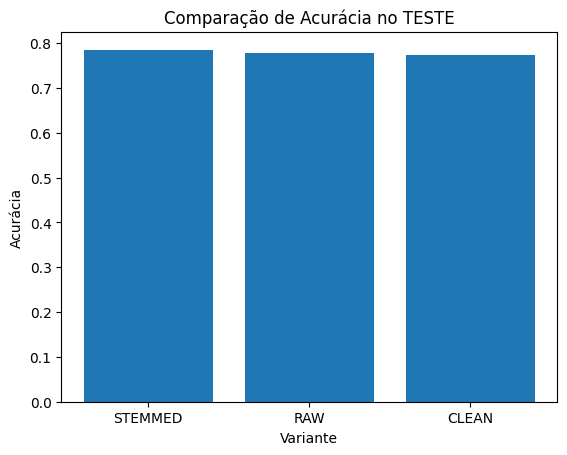




=== Comparação de Acurácia no TESTE ===


,Variante,Acurácia_TESTE,Épocas,Emb_dim,Hidden_dim
0,STEMMED,0.7855,5,200,256
1,RAW,0.7778,5,200,256
2,CLEAN,0.7727,5,200,256


In [288]:
# ===== Tabela de resultados e gráfico comparativo (TESTE) =====
import pandas as pd
import matplotlib.pyplot as plt

rows = []
for name in variant_order:
    rows.append({
        "Variante": name,
        "Acurácia_TESTE": round(test_scores.get(name, float("nan")), 4),
        "Épocas": EPOCHS,
        "Emb_dim": EMB_DIM,
        "Hidden_dim": HIDDEN_DIM,
    })

df_res = (
    pd.DataFrame(rows)
    .sort_values("Acurácia_TESTE", ascending=False)
    .reset_index(drop=True)
)

# Gráfico comparativo
plt.figure()
plt.bar(df_res["Variante"], df_res["Acurácia_TESTE"])
plt.title("Comparação de Acurácia no TESTE")
plt.xlabel("Variante")
plt.ylabel("Acurácia")
plt.show()

# Exibir como DataFrame padrão
print("\n\n\n=== Comparação de Acurácia no TESTE ===")
df_res

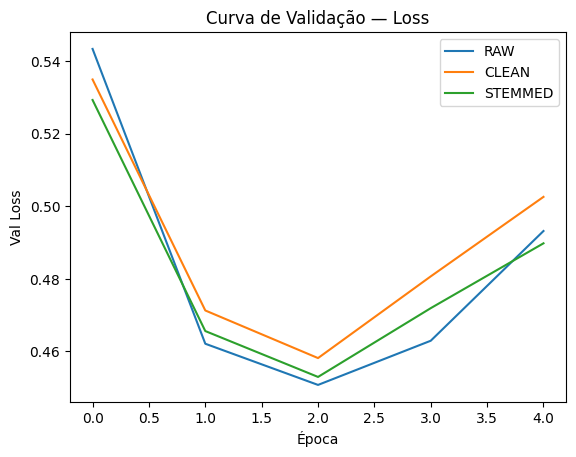

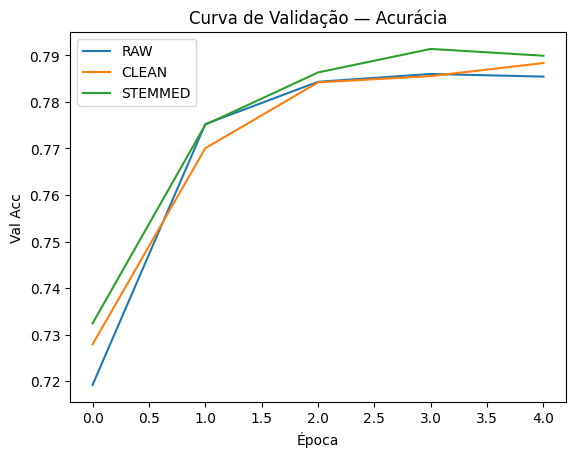

In [289]:
# ===== Curvas de erro (val_loss e val_acc) por variante =====
# (um gráfico por métrica, com linhas para cada variante)
plt.figure()
for name in variant_order:
    plt.plot(histories[name]["va_loss"], label=f"{name}")
plt.title("Curva de Validação — Loss")
plt.xlabel("Época"); plt.ylabel("Val Loss"); plt.legend(); plt.show()

plt.figure()
for name in variant_order:
    plt.plot(histories[name]["va_acc"], label=f"{name}")
plt.title("Curva de Validação — Acurácia")
plt.xlabel("Época"); plt.ylabel("Val Acc"); plt.legend(); plt.show()

In [290]:
# ===== 5 exemplos do TESTE com predições lado a lado =====
rng = np.random.default_rng(SEED)
sample_idx = rng.choice(splits["test"], size=min(5, len(splits["test"])), replace=False)

def decode(ids, idx2word, pad_idx):
    toks = [idx2word.get(int(i), "<OOV>") for i in ids if int(i) != pad_idx]
    return " ".join(toks)

print("\n=== 5 Exemplos do TESTE ===")
for j, i in enumerate(sample_idx):
    print(f"\nExemplo {j+1} — idx={int(i)} | y_true={int(y[i])}")
    # Mostra o RAW original se existir, senão usa CLEAN
    if "RAW" in variants:
        original_text = variants["RAW"][i]
    elif "CLEAN" in variants:
        original_text = variants["CLEAN"][i]
    else:
        first_key = next(iter(variants.keys()))
        original_text = variants[first_key][i]
    print("Texto:", (original_text[:280] + ("..." if len(original_text) > 280 else "")))
    # Predições por variante
    for name in variant_order:
        X_var = seq_buckets[name]["X"]
        pad_idx = pad_idx_map[name]
        idx2word = seq_buckets[name]["idx2word"]
        # Produz prob/pred para este exemplo
        xb = torch.from_numpy(X_var[i:i+1]).to(device)
        with torch.no_grad():
            p = torch.sigmoid(models[name](xb)).item()
        pred = int(p >= 0.5)
        print(f"  {name:<8} → pred={pred}  prob={p:.3f}")


=== 5 Exemplos do TESTE ===

Exemplo 1 — idx=61406 | y_true=0
Texto: @kellyappleby What happened to Ms Alba? Don't tell me she was a fake too. 
  RAW      → pred=0  prob=0.072
  CLEAN    → pred=0  prob=0.014
  STEMMED  → pred=0  prob=0.016

Exemplo 2 — idx=37554 | y_true=0
Texto: @gaylejack Am reading a book for review so I can't play on blip 2nite 
  RAW      → pred=1  prob=0.818
  CLEAN    → pred=0  prob=0.047
  STEMMED  → pred=0  prob=0.457

Exemplo 3 — idx=11518 | y_true=1
Texto: @savagestar Sounds like you won backstage passes 
  RAW      → pred=1  prob=0.928
  CLEAN    → pred=1  prob=0.850
  STEMMED  → pred=1  prob=0.910

Exemplo 4 — idx=20237 | y_true=0
Texto: i wanna go to a place where its warm.  IT SNOWED YESTURDAY!  Its may thats not sapose to happen 
  RAW      → pred=0  prob=0.015
  CLEAN    → pred=0  prob=0.013
  STEMMED  → pred=0  prob=0.188

Exemplo 5 — idx=63590 | y_true=0
Texto: Have upgraded iPhone to 3.0. Seemed to work OK, now can't get off the &quot;emergency cal